<a href="https://colab.research.google.com/github/ritik007soni/Stock-Trend-Prediction/blob/main/StockTrends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing yfinacne api

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


FinTA (Financial Technical Analysis):

Common financial technical indicators implemented in Pandas.
* Simple Moving Average 'SMA'
* Simple Moving Median 'SMM'
* Smoothed Simple Moving Average 'SSMA'
* Exponential Moving Average 'EMA', etc.

In [ ]:
pip install finta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
from finta import TA
import matplotlib.pyplot as plt

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'TCS.NS'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
                   open         high          low        close    Adj Close  \
Date                                                                          
2022-08-16  3411.000000  3414.850098  3387.500000  3392.699951  3383.942139   
2022-08-17  3385.100098  3417.949951  3371.100098  3401.100098  3392.320557   
2022-08-18  3390.000000  3392.000000  3362.000000  3381.250000  3372.521729   
2022-08-19  3387.000000  3421.500000  3371.250000  3385.750000  3377.010254   
2022-08-22  3365.000000  3384.100098  3347.399902  3354.550049  3345.890869   
2022-08-23  3319.949951  3341.899902  3270.000000  3284.600098  3276.121338   
2022-08-24  3292.000000  3308.000000  3250.199951  3255.350098  3246.946777   
2022-08-25  3276.000000  3278.149902  3214.750000  3218.199951  3209.892578   
2022-08-26  3234.300049  3257.000000  3216.800049  3222.199951  3213.882324   
2022-08-29  3125.000000  3142.699951  3081.000000  3132.550049

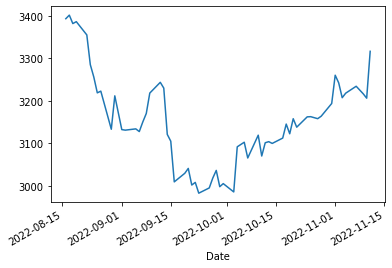

In [ ]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
#print(data.head())

tmp = data.iloc[-60:] #Getting data of last 60 rows.
print(tmp)
tmp['close'].plot()

                   open         high          low        close    Adj Close  \
Date                                                                          
2022-08-16  3410.446816  3415.502604  3382.841399  3395.652073  3386.886677   
2022-08-17  3393.971449  3417.093380  3375.209553  3399.193289  3390.418699   
2022-08-18  3391.390007  3400.782683  3366.623344  3387.530151  3378.785668   
2022-08-19  3388.536503  3414.248939  3369.630670  3386.373053  3377.631649   
2022-08-22  3373.237776  3394.652192  3355.180671  3365.688100  3357.000142   
2022-08-23  3338.600690  3360.363204  3299.813235  3312.980899  3304.428919   
2022-08-24  3308.310241  3326.327121  3267.564600  3275.520878  3267.065527   
2022-08-25  3287.308585  3295.011929  3233.235110  3238.262276  3229.903110   
2022-08-26  3252.853036  3270.304175  3222.552320  3227.821765  3219.489599   
2022-08-29  3169.748563  3187.361430  3130.543312  3165.895149  3157.722873   
2022-08-30  3160.161997  3212.801500  3138.055223  3

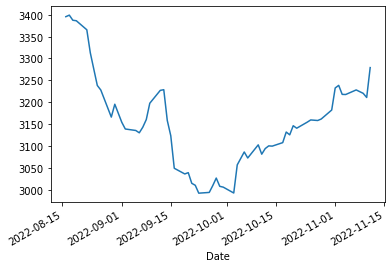

In [ ]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
print(tmp1)
tmp1['close'].plot()

In [ ]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


Right before we gather our predictions, I decided to keep a small bit of data to predict future values with. This line captures 5 rows corresponding to the 5 days of the week on July 27th.

In [ ]:
live_pred_data = data.iloc[-16:-11]
print(live_pred_data)

                  close  14 period RSI       MACD     SIGNAL  \
Date                                                           
2022-10-19  3125.283591      55.651459  -3.139738 -19.418033   
2022-10-20  3146.094288      59.195057   1.269254 -15.280575   
2022-10-21  3140.442937      57.843392   4.258309 -11.372798   
2022-10-24  3154.259996      60.234183   7.653848  -7.567469   
2022-10-25  3159.356062      61.110207  10.633471  -3.927281   

            14 period STOCH %K           MFV  14 period ATR        MOM  \
Date                                                                     
2022-10-19           84.675931 -3.071529e+08      63.867932  68.777668   
2022-10-20           93.833619 -3.063485e+08      62.808410  60.049747   
2022-10-21           89.892147 -3.063096e+08      60.756865  68.142412   
2022-10-24           89.646056 -3.064279e+08      59.102648  51.897281   
2022-10-25           86.870310 -3.068846e+08      55.646621  78.321580   

            14 period MFI       

In [ ]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2022-10-13,51.487521,-18.992086,-35.855353,81.049380,-3.073876e+08,66.337468,73.648773,59.723436,3.558144,1.221397e+09,83.259525,126.526395,0.900523,1.050891,0.960552,0.992125,1.001302,1.009334,0.873174,1.0
2022-10-14,51.385976,-15.289183,-31.742119,80.311068,-3.074824e+08,68.245358,91.979475,66.505359,3.003738,1.219165e+09,112.715719,178.406373,0.867600,1.068087,0.961129,0.992313,1.001050,1.007618,0.901079,1.0
2022-10-17,52.848713,-11.575763,-27.708848,83.037972,-3.070768e+08,66.925974,101.872785,73.608472,2.679787,1.220932e+09,108.186726,216.415611,0.869556,1.113085,0.964298,0.995106,1.003390,1.008501,0.749271,1.0
2022-10-18,57.061344,-6.602639,-23.487606,91.706247,-3.066865e+08,65.455839,139.492975,73.177142,4.129550,1.222716e+09,132.663811,242.398132,0.848199,1.136013,0.972350,1.002731,1.010455,1.013596,0.788577,1.0
2022-10-19,55.651459,-3.139738,-19.418033,84.675931,-3.071529e+08,63.867932,68.777668,72.209896,3.983044,1.221316e+09,116.661599,231.419913,0.853422,1.131892,0.970934,1.000658,1.007833,1.009592,0.661028,1.0
